<a href="https://colab.research.google.com/github/maheravi/Deep-Learning/blob/main/PyTorch%20Age%20Prediction%20Using%20Face%20Image%20TL/PyTorch_Age_Prediction_Using_Face_Image_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle
!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d jangedoo/utkface-new


 97% 321M/331M [00:06<00:00, 47.0MB/s]
100% 331M/331M [00:06<00:00, 54.7MB/s]


In [3]:
!unzip -qq utkface-new.zip

In [4]:
!pip install wandb
import wandb

     |████████████████████████████████| 1.7 MB 13.8 MB/s 
     |████████████████████████████████| 97 kB 6.1 MB/s 
     |████████████████████████████████| 142 kB 84.9 MB/s 
     |████████████████████████████████| 180 kB 96.1 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=7ecf1952780b698af205604ead7865998826aeca68a4a5728d53ff76f3e33b34
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=2f0c2575021f95c20e2e34bea996facd2e34bf165e44665233a07346163aee45
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools


In [5]:
import torch
from torch import nn
import torchvision
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import os
import cv2
import numpy as np

In [7]:
import wandb

wandb.init(project="AgePredictionTL", entity="ma_heravi")

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [22]:
# hyperparameters
latent_size = 10
disc_inp_sz = 224*224
img_size = 224
epochs = 10
batch_size = 32
lr = 0.001
width = height = 224
wandb.config = {
  "learning_rate": lr,
  "epochs": epochs,
  "batch_size": batch_size
}

In [9]:
images = []
ages = []

for image_name in os.listdir('crop_part1')[0:9000]:
    part = image_name.split('_')
    ages.append(int(part[0]))

    image = cv2.imread(f'crop_part1/{image_name}')
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)

In [10]:
images = pd.Series(images, name= 'Images')
ages = pd.Series(ages, name= 'Ages')

df = pd.concat([images, ages], axis= 1)
df.head()

,Images,Ages
0,"[[[177, 158, 128], [160, 141, 111], [148, 127,...",85
1,"[[[130, 142, 164], [130, 142, 164], [131, 142,...",54
2,"[[[248, 253, 255], [248, 253, 255], [248, 254,...",5
3,"[[[122, 67, 36], [110, 55, 24], [95, 42, 11], ...",52
4,"[[[201, 200, 195], [209, 208, 203], [220, 219,...",32


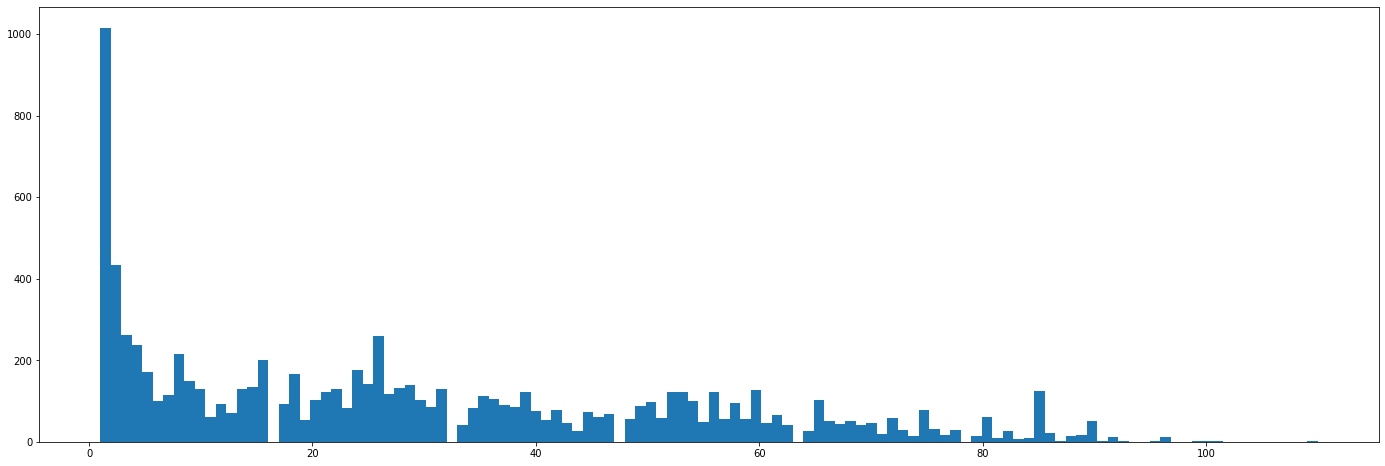

In [11]:
plt.figure(figsize=(24, 8))
plt.hist(df['Ages'], bins= 116)
plt.show()

In [12]:
under4 = []

for i in range(len(df)):
    if df['Ages'].iloc[i] <= 4:
        under4.append(df.iloc[i])

under4 = pd.DataFrame(under4)
under4 = under4.sample(frac= 0.3)

up4 = df[df['Ages'] > 4]

df = pd.concat([under4, up4])

In [13]:
df = df[df['Ages'] < 90]

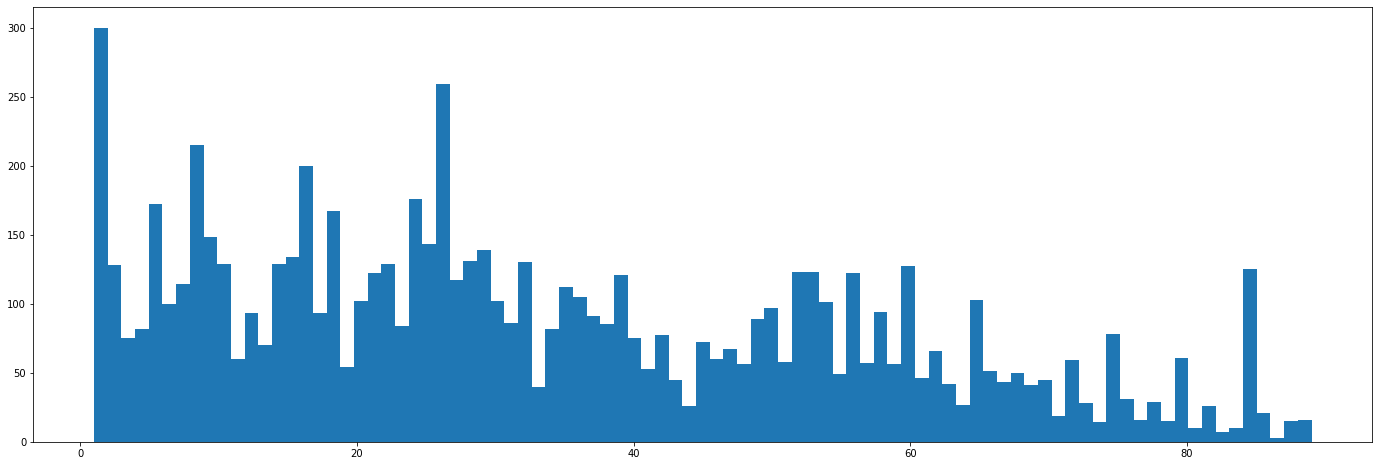

In [14]:
plt.figure(figsize=(24, 8))
plt.hist(df['Ages'], bins= 89)
plt.show()

In [15]:
X = []
Y = []

for i in range(len(df)):
    df['Images'].iloc[i] = cv2.resize(df['Images'].iloc[i], (width, height))

    X.append(df['Images'].iloc[i])
    Y.append(df['Ages'].iloc[i])

X = np.array(X)
Y = np.array(Y)

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [16]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2)

In [17]:
# X_train = X_train.astype(np.float32)

In [18]:
X_train = torch.tensor(X_train)
Y_train = torch.tensor(Y_train)
X_train = torch.permute(X_train, (0, 3, 2, 1))

In [19]:
# from torch.utils.data import TensorDataset

In [20]:
class MyDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.data = X
        self.target = y
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index]

        # Normalize your data here
        if self.transform:
            x = self.transform(x)

        return x, y
    
    def __len__(self):
        return len(self.data)

transform = torchvision.transforms.Compose([
        torchvision.transforms.ToPILImage(),
        torchvision.transforms.Resize((28, 28)),
        torchvision.transforms.RandomHorizontalFlip(),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
])

In [21]:
dataset = MyDataset(X_train, Y_train, transform)
train_data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = torchvision.models.resnet50(pretrained=True)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features,1)

ct = 0
for child in model.children():
    ct += 1
    if ct < 7:
        for param in child.parameters():
            param.requires_grad = False

model = model.to(device)


In [27]:
 # compile
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_function = torch.nn.MSELoss()

In [28]:
# train
wandb.watch(model)

for epoch in range(1, epochs+1):
    train_loss = 0.0
    train_acc = 0.0
    for images, labels in train_data_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # 1- forwarding
        preds = model(images)
        # print(labels)
        # print(preds)
        # 2- backwarding
        loss = loss_function(preds, labels.float())
        loss.backward()
        # 3- Update
        optimizer.step()

        train_loss += loss
    
    total_loss = train_loss / len(train_data_loader)

    print(f"Epoch: {epoch}, Loss: {total_loss}")
    wandb.log({'epochs':  epoch,
              'loss': total_loss,
                              })

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:520: UserWarning: Using a target size (torch.Size([18])) that is different to the input size (torch.Size([18, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch: 1, Loss: 599.234130859375
Epoch: 2, Loss: 533.0835571289062
Epoch: 3, Loss: 531.4361572265625
Epoch: 4, Loss: 531.2455444335938
Epoch: 5, Loss: 531.7100830078125
Epoch: 6, Loss: 531.7698364257812
Epoch: 7, Loss: 531.0797119140625
Epoch: 8, Loss: 531.2728881835938
Epoch: 9, Loss: 530.3558349609375
Epoch: 10, Loss: 531.17626953125


In [29]:
# save
torch.save(model.state_dict(), "FaceAgePredictionTL.pth")